In [1]:
!python -m pip install swifter
# %reset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import collections
import os.path
import seaborn as sns
%matplotlib inline

In [3]:
from datetime import datetime
from dateutil import tz
import pytz

In [4]:
import swifter

In [5]:
# additional functions

def ep_to_day(ep) -> str:
    return datetime.fromtimestamp(ep/1000).strftime("%A")
def get_part_of_day(datetime) -> str:
    return (
        "morning" if 5 <= datetime.hour <= 11
        else
        "afternoon" if 12 <= datetime.hour <= 17
        else
        "evening" if 18 <= datetime.hour <= 22
        else
        "night"
    )

<div class="WordSection1">
<h2><a name="_bznuingq19sm"></a><span lang="EN">Task</span></h2>
<p class="MsoNormal"><span lang="EN">You are required to design a bidding strategy
given the dataset at hand.</span></p>
<p class="MsoNormal"><span lang="EN"><o:p>&nbsp;</o:p></span></p>
<p class="MsoNormal"><span lang="EN">We would like you to follow these steps:</span></p>
<ol style="margin-top:0in" start="1" type="1">
 <li class="MsoNormal" style="mso-list:l1 level1 lfo3"><span lang="EN">Rank
     existing features importance</span></li>
 <li class="MsoNormal" style="mso-list:l1 level1 lfo3"><span lang="EN">Engineer new
     features (e.g. day-of-week)</span></li>
 <li class="MsoNormal" style="mso-list:l1 level1 lfo3"><span lang="EN">Optional:
     Enrich the dataset with external sources (e.g. <span class="SpellE">timezones</span>,
     app categories)</span></li>
 <li class="MsoNormal" style="mso-list:l1 level1 lfo3"><span lang="EN">Predict
     whether the user clicked the ads or not (evaluate the performance) using
     the features from questions 1, 2, 3.</span></li>
</ol>
<p class="MsoNormal"><span lang="EN"><o:p>&nbsp;</o:p></span></p>
<p class="MsoNormal"><u><span lang="EN">Tips:</span></u></p>
<ol style="margin-top:0in" start="1" type="1">
 <li class="MsoNormal" style="mso-list:l0 level1 lfo1"><span lang="EN">If you split
     the data to train and test sets, do it wisely and not at random</span></li>
 <li class="MsoNormal" style="mso-list:l0 level1 lfo1"><span lang="EN">A
     combination of features could be more helpful than a single feature
     prediction.</span></li>
 <li class="MsoNormal" style="mso-list:l0 level1 lfo1"><span lang="EN">If you
     filtered data out, make sure you have enough records to have a statistical
     significant prediction.</span></li>
</ol>
</div>

# Exploration data and ranking existing features importance


In [8]:
df = pd.read_csv("../data/raw/android_bids_us.csv")

In [18]:
df.head(5)

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0


In [19]:
df.describe()

,utc_time,device_height,device_width,click
count,3.148828e+06,3.148828e+06,3.148828e+06,3.148828e+06
mean,1.538334e+12,1.180970e+03,1.152078e+03,6.770741e-02
std,2.320255e+09,5.190901e+02,4.526602e+02,2.512432e-01
min,1.533578e+12,1.400000e+01,1.400000e+01,0.000000e+00
25%,1.536460e+12,7.200000e+02,7.200000e+02,0.000000e+00
50%,1.538472e+12,1.080000e+03,1.080000e+03,0.000000e+00
75%,1.540095e+12,1.280000e+03,1.280000e+03,0.000000e+00
max,1.542630e+12,3.120000e+03,3.120000e+03,1.000000e+00


In [21]:
df.isna().sum()

bidid                 0
utc_time              0
app_id                0
user_state            0
user_isp             39
device_maker     964004
device_model     963858
device_osv            0
device_height         0
device_width          0
marketplace           0
click                 0
dtype: int64

In [22]:
df["device_osv"].unique()

array(['7.0', '7.1.1', '6.0.1', '8.0.0', '7.1.2', '8.1.0', '6.0', '9',
       '8.0', 'CONTIXO-LA703-20180915-v1.0', '7.1', 'P', 'M', '6.1',
       'unknown', '4.4.4 KitKat Os For 9inch QuadCore Tablet Pc',
       '5.0 by mrkindaiji', 'O', '7.0.1', '8.0.1'], dtype=object)

In [35]:
df["app_id"].unique()

array(['com.OppanaGames.CarSim', 'com.mobilityware.CrownSolitaire',
       'com.kuttigames.tenkyurollball', ...,
       'air.com.pixelstudio8.snake.io', 'com.te.highschool.girl',
       'com.casino.party.slots.my.lucky.vegas.free.slots777.games'],
      dtype=object)

In [36]:
df.groupby(['app_id']).mean()["click"].nlargest(10)  

app_id
bitcoin.alien.run                           1.0
com.gbmediagroup.velociraptorgo             1.0
com.topgamestudio.orangeblockprisonbreak    1.0
air.com.goda.games.picquiz                  0.5
air.sjv                                     0.5
aul.irm.lingo                               0.5
baccardo.quiz.logoquiz                      0.5
br.com.tapps.weddingdressdesigner           0.5
candy.sweet.sugar.smash                     0.5
co.ubergeek.unicornpopa                     0.5
Name: click, dtype: float64

clicking model probably depends on the app_id and from app_id we could found out category app

In [10]:
df.groupby('user_state')['click'].describe()

,count,mean,std,min,25%,50%,75%,max
user_state,,,,,,,,
AK,3144.0,0.045165,0.207700,0.0,0.0,0.0,0.0,1.0
AL,47200.0,0.067691,0.251217,0.0,0.0,0.0,0.0,1.0
AR,18762.0,0.067583,0.251036,0.0,0.0,0.0,0.0,1.0
AZ,53728.0,0.071862,0.258262,0.0,0.0,0.0,0.0,1.0
CA,394602.0,0.070063,0.255253,0.0,0.0,0.0,0.0,1.0
CO,44615.0,0.064956,0.246450,0.0,0.0,0.0,0.0,1.0
CT,13267.0,0.065049,0.246621,0.0,0.0,0.0,0.0,1.0
DC,26902.0,0.065534,0.247471,0.0,0.0,0.0,0.0,1.0
DE,4185.0,0.075269,0.263856,0.0,0.0,0.0,0.0,1.0


In [28]:
rate_click = df["click"].astype(bool).sum(axis=0)/len(df["click"])
rate_click

0.06770741367899422

In [38]:
table = df.pivot_table(values="bidid", columns="click", index="user_state", aggfunc=len)
table["total"] = table[0]+table[1]
table["rate"] = table[1].div(table["total"])
table["ctr"] = table["rate"] - rate_click
table

click,0,1,total,rate,ctr
user_state,,,,,
AK,3002,142,3144,0.045165,-0.022542
AL,44005,3195,47200,0.067691,-0.000017
AR,17494,1268,18762,0.067583,-0.000124
AZ,49867,3861,53728,0.071862,0.004155
CA,366955,27647,394602,0.070063,0.002356
CO,41717,2898,44615,0.064956,-0.002752
CT,12404,863,13267,0.065049,-0.002659
DC,25139,1763,26902,0.065534,-0.002173
DE,3870,315,4185,0.075269,0.007561


In [60]:
from scipy.stats import ttest_ind, binom_test

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'CTR Distribution')]

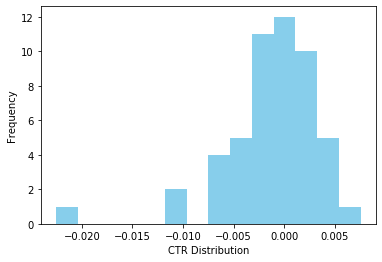

In [59]:
ax = sns.distplot(table["ctr"],
                  kde=False,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='CTR Distribution', ylabel='Frequency')

How do you find the significant difference?
Statistical Significance
Usually, statistical significance is determined by calculating the probability of error (p value) by the t ratio.
The difference between two groups (such as an experiment vs. control group) is judged to be statistically significant when p = 0.05 or less.

Cause we have binary value (click - 0 - 1) I assume that it's better fit to the binomial distribution


In [65]:
table["pvalue"] = table.apply(lambda row: binom_test(row[1], row["total"], p = rate_click, alternative="two-sided"), axis=1)
table

click,0,1,total,rate,ctr,pvalue
user_state,,,,,,
AK,3002,142,3144,0.045165,-0.022542,1.394232e-07
AL,44005,3195,47200,0.067691,-0.000017,1.000000e+00
AR,17494,1268,18762,0.067583,-0.000124,9.652321e-01
AZ,49867,3861,53728,0.071862,0.004155,1.425660e-04
CA,366955,27647,394602,0.070063,0.002356,4.599258e-09
CO,41717,2898,44615,0.064956,-0.002752,2.045892e-02
CT,12404,863,13267,0.065049,-0.002659,2.265017e-01
DC,25139,1763,26902,0.065534,-0.002173,1.592683e-01
DE,3870,315,4185,0.075269,0.007561,5.260812e-02


In [68]:
table.query("pvalue>0.005")

click,0,1,total,rate,ctr,pvalue
user_state,,,,,,
AL,44005,3195,47200,0.067691,-0.000017,1.000000
AR,17494,1268,18762,0.067583,-0.000124,0.965232
CO,41717,2898,44615,0.064956,-0.002752,0.020459
CT,12404,863,13267,0.065049,-0.002659,0.226502
DC,25139,1763,26902,0.065534,-0.002173,0.159268
DE,3870,315,4185,0.075269,0.007561,0.052608
FL,245078,18129,263207,0.068877,0.001170,0.017050
GA,118463,8678,127141,0.068255,0.000548,0.437865
HI,10562,799,11361,0.070328,0.002621,0.262626


In [69]:
table.query("pvalue<=0.005")

click,0,1,total,rate,ctr,pvalue
user_state,,,,,,
AK,3002,142,3144,0.045165,-0.022542,1.394232e-07
AZ,49867,3861,53728,0.071862,0.004155,1.425660e-04
CA,366955,27647,394602,0.070063,0.002356,4.599258e-09
IA,23154,1504,24658,0.060994,-0.006713,2.172082e-05
IL,181598,12781,194379,0.065753,-0.001954,5.824927e-04
ME,4487,269,4756,0.056560,-0.011147,2.002592e-03
MN,33283,2141,35424,0.060439,-0.007268,3.374897e-08
NV,31843,2463,34306,0.071795,0.004088,2.814876e-03
NY,167995,12551,180546,0.069517,0.001809,2.295386e-03


also model could depends on state, but I don't think that in our case it's possible ranging based on the geography, but we can obtain from state, timezone (also we have utc and we could get local time and timezone also). I found for this https://pypi.org/project/us/

In [30]:
!python -m pip install us

In [32]:
import us

In [34]:
def convert_to_local_time(state, utc_timestamp) -> datetime:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(us.states.lookup(state).capital_tz)
    utc = datetime.utcfromtimestamp(utc_timestamp / 1000)
    utc = utc.replace(tzinfo=from_zone)
    return utc.astimezone(to_zone)

In [37]:
def get_time_zone_repr(state) -> str:
    return datetime.now(tz.gettz(us.states.lookup(state).capital_tz)).strftime('%Z')

In [4]:
# I save the data, 'cause on my laptop it's too slow processing data each time, 
# that's why I also found swifter https://github.com/jmcarpenter2/swifter
if os.path.isfile("../data/raw/android_bids_us_additional.csv"):
    df = pd.read_csv("../data/raw/android_bids_us_additional.csv")
else:
    df = df.reset_index(drop=True)
    dict_zone_code = collections.defaultdict(str,dict(map(lambda state: (state, get_time_zone_repr(state)), df["user_state"].unique())))
    df["day_of_week"] = df.swifter.apply(lambda row: ep_to_day(row["utc_time"]), axis=1)
    df["local_time"] = df.swifter.apply(lambda row: convert_to_local_time(row["user_state"], row["utc_time"]), axis=1)
    df["part_of_day"] = df.swifter.apply(lambda row: get_part_of_day(row["local_time"]), axis=1)
    df["time_zone_code"] = df.swifter.apply(lambda row: dict_zone_code.get(row["user_state"]), axis=1)
    df.to_csv(path_or_buf = "../data/raw/android_bids_us_additional.csv", index=False)

In [39]:
df.columns

Index(['bidid', 'utc_time', 'app_id', 'user_state', 'user_isp', 'device_maker',
       'device_model', 'device_osv', 'device_height', 'device_width',
       'marketplace', 'click', 'day_of_week', 'local_time', 'part_of_day',
       'time_zone_code', 'hour'],
      dtype='object')

In [40]:
df.groupby('time_zone_code')['click'].describe()

,count,mean,std,min,25%,50%,75%,max
time_zone_code,,,,,,,,
AKST,3144.0,0.045165,0.207700,0.0,0.0,0.0,0.0,1.0
CST,1036169.0,0.066094,0.248447,0.0,0.0,0.0,0.0,1.0
EST,1426086.0,0.068274,0.252215,0.0,0.0,0.0,0.0,1.0
HST,11361.0,0.070328,0.255711,0.0,0.0,0.0,0.0,1.0
MST,139473.0,0.067820,0.251437,0.0,0.0,0.0,0.0,1.0
PST,532595.0,0.069377,0.254095,0.0,0.0,0.0,0.0,1.0


Text(0, 0.5, 'time zone code')

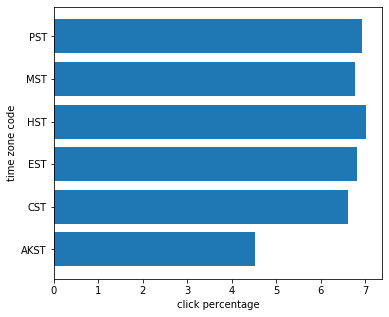

In [45]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
pt = pd.pivot_table(df, index=["time_zone_code"], values='click', aggfunc='mean')
pt = pt * 100
plt.barh(y=pt.index, width=pt['click'])
plt.xlabel('click percentage')
plt.ylabel('time zone code')



In [47]:
df.groupby('part_of_day')['click'].describe()

,count,mean,std,min,25%,50%,75%,max
part_of_day,,,,,,,,
afternoon,1095471.0,0.067723,0.251271,0.0,0.0,0.0,0.0,1.0
evening,710956.0,0.066584,0.249300,0.0,0.0,0.0,0.0,1.0
morning,807810.0,0.070509,0.256003,0.0,0.0,0.0,0.0,1.0
night,534591.0,0.064936,0.246412,0.0,0.0,0.0,0.0,1.0


as we see , our model depends on the time (on the part of day, and it is logically clear, I also think there is correlations based also on the Weekends, on the holidays and so on.) about app_id. I grab data from https://play.google.com/store/apps/details?id={}&hl=en&gl=us - source code in the ./src/data/make_dataset.py but a lot of app_id are undefined, because those apps were already removed from the market, 
https://gist.github.com/imvladikon/982653b574f9bd3644a2aace84874311

In [7]:
category_df = pd.read_csv("../data/processed/cat_app_ids.csv")

In [8]:
category_df[category_df["category_app"] == "UNKNOWN"].count()

app_id          5559
category_app    5559
dtype: int64

In [52]:
category_df.head(5)

,app_id,category_app
0,com.degoo.android.mermaidtwins,UNKNOWN
1,com.boxlotto.boxlottosweepstakes,GAME_CASINO
2,com.gamerstech3d.us.army.training.commando.cou...,GAME_SIMULATION
3,com.sinyee.babybus.born,UNKNOWN
4,com.psvn.SpagettiNew,GAME_CASUAL


In [13]:
if os.path.isfile("../data/raw/android_bids_us_category.csv"):
    df_cat = pd.read_csv("../data/raw/android_bids_us_category.csv")
else:
    df_cat_app = category_df[category_df["category_app"] != "UNKNOWN"]
    df_cat_app = df_cat_app[df_cat_app["category_app"].notnull()]
    dict_cat_app = {}
    for index, row in df_cat_app.iterrows():
        dict_cat_app[row["app_id"]] = row["category_app"]
    df_cat = df.reset_index(drop=True)
    df["category_app"] = df.swifter.apply(lambda row: dict_cat_app.get(row["app_id"]), axis=1)    
    df_cat = df[df["category_app"] != "UNKNOWN"]
    df_cat = df_cat[df_cat["category_app"].notnull()]
    df_cat.to_csv(path_or_buf = "../data/raw/android_bids_us_category.csv", index=False)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755991 entries, 0 to 2755990
Data columns (total 18 columns):
bidid             object
utc_time          int64
app_id            object
user_state        object
user_isp          object
device_maker      object
device_model      object
device_osv        object
device_height     int64
device_width      int64
marketplace       object
click             int64
day_of_week       object
local_time        object
part_of_day       object
time_zone_code    object
hour              int64
category_app      object
dtypes: int64(5), object(13)
memory usage: 378.5+ MB


In [26]:
len(np.unique(df[['device_height', 'device_width']], axis=0))

554

In [38]:
df_cat.groupby(['category_app']).mean()["click"].nlargest(10)  

category_app
BOOKS_AND_REFERENCE    0.206522
SPORTS                 0.172093
PERSONALIZATION        0.153385
NEWS_AND_MAGAZINES     0.148148
COMMUNICATION          0.142857
GAME_MUSIC             0.132087
GAME_EDUCATIONAL       0.131911
PRODUCTIVITY           0.128801
ENTERTAINMENT          0.117880
VIDEO_PLAYERS          0.095238
Name: click, dtype: float64

There is also an assumption that there is a dependence on the device (tablet, smartphone, orientation)

In [16]:
if os.path.isfile("../data/raw/android_bids_us_datetime.csv"):
    df_time = pd.read_csv("../data/raw/android_bids_us_datetime.csv")
else:
    df_time = df.copy()
    df_time = df_time.reset_index(drop=True)
    df_time["local_time"] = pd.to_datetime(df["local_time"])
    df_time["month"] = df_time.swifter.apply(lambda row: row["local_time"].month, axis=1)
    df_time["year"] = df_time.swifter.apply(lambda row: row["local_time"].year, axis=1)
    df_time["day"] = df_time.swifter.apply(lambda row: row["local_time"].day, axis=1)
    df_time["day_of_week"] = df_time.swifter.apply(lambda row: row["local_time"].weekday(), axis=1)
    df_time["hour"] = df_time.swifter.apply(lambda row: row["local_time"].hour, axis=1)
    df_time['is_weekend'] = df_time.swifter.apply(lambda row: int(row["day_of_week"]>=5), axis=1)
    df_time = df_time.drop(["local_time"], axis=1)
    df_time = df_time.drop(["local_time","user_isp","device_maker","device_model","device_osv","device_height","device_width","marketplace"], axis=1)
    df_time.to_csv(path_or_buf = "../data/raw/android_bids_us_datetime.csv", index=False)
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3148828 entries, 0 to 3148827
Data columns (total 20 columns):
bidid             object
utc_time          int64
app_id            object
user_state        object
user_isp          object
device_maker      object
device_model      object
device_osv        object
device_height     int64
device_width      int64
marketplace       object
click             int64
day_of_week       int64
part_of_day       object
time_zone_code    object
hour              int64
month             int64
year              int64
day               int64
is_weekend        int64
dtypes: int64(10), object(10)
memory usage: 480.5+ MB


In [39]:
df_time.groupby('month')['click'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
8,543523.0,0.051622,0.221264,0.0,0.0,0.0,0.0,1.0
9,954810.0,0.068396,0.252424,0.0,0.0,0.0,0.0,1.0
10,1192419.0,0.072713,0.259664,0.0,0.0,0.0,0.0,1.0
11,458076.0,0.072329,0.259032,0.0,0.0,0.0,0.0,1.0


In [44]:
df_time.groupby(['hour']).mean()["click"].nlargest(10)  

hour
7     0.073684
9     0.072070
10    0.071893
8     0.071840
11    0.069444
17    0.068960
12    0.068805
18    0.068722
19    0.068207
16    0.067841
Name: click, dtype: float64

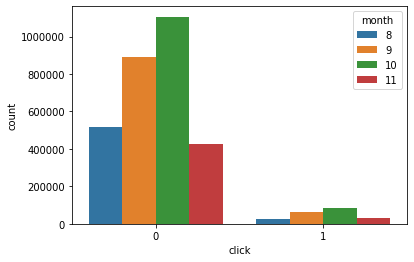

In [43]:
sns.countplot(df_time["click"], hue = df_time["month"])
#strange that plot represents only 4 month, maybe I something missed when processed data

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label
from sklearn.model_selection import train_test_split

as we see, model data depends on specific times feature as month for example, therefore we could divide data set to train set and set based on month values

In [23]:
df_time.columns

Index(['bidid', 'utc_time', 'app_id', 'user_state', 'user_isp', 'device_maker',
       'device_model', 'device_osv', 'device_height', 'device_width',
       'marketplace', 'click', 'day_of_week', 'part_of_day', 'time_zone_code',
       'hour', 'month', 'year', 'day', 'is_weekend'],
      dtype='object')

In [17]:
df_time = df_time.drop(["bidid", "utc_time", "app_id", "user_state", "user_isp", "device_maker", "device_model", "device_osv", 
             'device_height', 'device_width', 'marketplace']  , axis=1)

In [18]:
labeler = label.LabelEncoder()
df_time["time_zone_code"] = labeler.fit_transform(df_time["time_zone_code"])
df_time["part_of_day"] = labeler.fit_transform(df_time["part_of_day"])
df_test = df_time[(df_time.month==11)].drop(["day", "month"]  , axis=1)
df_train = df_time[(df_time.month<11)].drop(["day", "month"] , axis=1)

In [21]:
# x = df_time[['month', 'hour', 'day_of_week']]
# y = df_time['click']
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train, y_train = df_train.drop("click",axis=1), df_train.click
x_test, y_test = df_test.drop("click",axis=1), df_test.click

In [22]:
model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(x_train, y_train)
predictions_LR = model_1.predict(x_test)

print('Logistic regression accuracy:', accuracy_score(predictions_LR, y_test))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_test,predictions_LR))

Logistic regression accuracy: 0.9276713907735834

Confusion matrix:
[[424944      0]
 [ 33132      0]]


In [23]:
from sklearn.tree import DecisionTreeClassifier

model_2 = DecisionTreeClassifier()
model_2.fit(x_train, y_train)
predictions_DT = model_2.predict(x_test)

print('Decision tree accuracy:', accuracy_score(predictions_DT, y_test))
print('')
print('Confusion matrix:')
print(confusion_matrix(y_test,predictions_DT))

Decision tree accuracy: 0.9276713907735834

Confusion matrix:
[[424944      0]
 [ 33132      0]]
